In [33]:
# Step 1: Load and preprocess the data
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
import kagglehub
import matplotlib.pyplot as plt 
import seaborn as sns   

# Download latest version of the dataset
path = kagglehub.dataset_download("shivanandmn/multilabel-classification-dataset")

print("Path to dataset files:", path)

# Load the dataset
url_train = f'{path}/train.csv'
train_set  = pd.read_csv(url_train)

Path to dataset files: C:\Users\beato\.cache\kagglehub\datasets\shivanandmn\multilabel-classification-dataset\versions\1


In [34]:
train_set.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [35]:

train_set.drop(columns=['ID'], inplace=True)
# Preprocess the data

# Combine the category columns into a list of categories for each paper
categories = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']
train_set['Categories'] = train_set[categories].apply(lambda row: [cat for cat in categories if row[cat] == 1], axis=1)

train_set.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Categories
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,[Computer Science]
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,[Computer Science]
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,[Mathematics]
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,[Mathematics]
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,"[Computer Science, Statistics]"


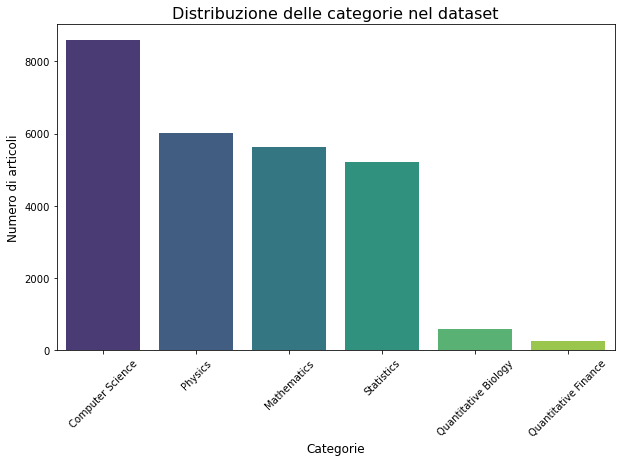

Number of occurrency for each category:
Computer Science: 8594
Physics: 6013
Mathematics: 5618
Statistics: 5206
Quantitative Biology: 587
Quantitative Finance: 249


In [36]:
# 1. Visualizzazione della distribuzione delle categorie
category_counts = train_set[categories].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title("Distribuzione delle categorie nel dataset", fontsize=16)
plt.ylabel("Numero di articoli", fontsize=12)
plt.xlabel("Categorie", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Stampa del numero di occorrenze per ogni categoria
print("Number of occurrency for each category:")
for category, count in category_counts.items():
    print(f"{category}: {count}")

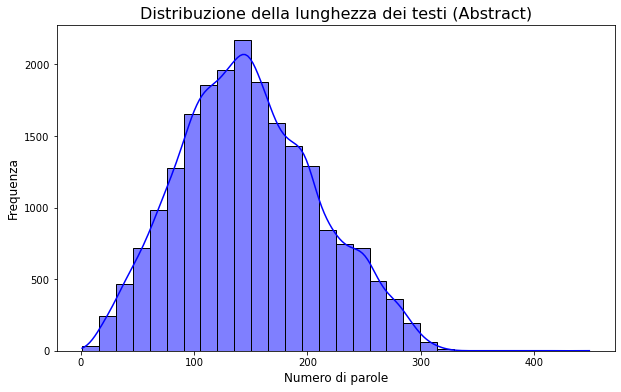

In [37]:
# 2. Esplorazione della lunghezza dei testi
# Aggiungiamo una colonna che rappresenta la lunghezza dell'abstract
train_set['Text_Length'] = train_set['ABSTRACT'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(train_set['Text_Length'], bins=30, kde=True, color='blue')
plt.title("Distribuzione della lunghezza dei testi (Abstract)", fontsize=16)
plt.xlabel("Numero di parole", fontsize=12)
plt.ylabel("Frequenza", fontsize=12)
plt.show()

In [39]:
from wordcloud import WordCloud
from collections import Counter

# Preprocess the text data
train_set['TITLE'] = train_set['TITLE'].str.lower().str.replace(r'[^\\w\\s]', '').str.replace(r'\\d+', '').str.strip()
train_set['ABSTRACT'] = train_set['ABSTRACT'].str.lower().str.replace(r'[^\\w\\s]', '').str.replace(r'\\d+', '').str.strip()
train_set['TEXT'] = train_set['TITLE'] + ' ' + train_set['ABSTRACT']

# Genera la WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    font_path="./ARIAL.TTF"  # Specifica il font
).generate(' '.join(train_set['TEXT']))

# Mostra la WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Parole più comuni negli abstract", fontsize=16)
plt.show()

C:\Users\beato\AppData\Local\Temp/ipykernel_26376/3149475183.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  train_set['TITLE'] = train_set['TITLE'].str.lower().str.replace(r'[^\\w\\s]', '').str.replace(r'\\d+', '').str.strip()
C:\Users\beato\AppData\Local\Temp/ipykernel_26376/3149475183.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  train_set['ABSTRACT'] = train_set['ABSTRACT'].str.lower().str.replace(r'[^\\w\\s]', '').str.replace(r'\\d+', '').str.strip()


ValueError: Only supported for TrueType fonts

In [ ]:
#generiamo un'altra word cloud solo sull'abstract, che restituisce come parole principali parole come 'the', 'and' ecc...
# perche lo facciamo? perchè successivamente con la rimozione delle stop words possiamo far vedere il cambiamento delle parole più comuni
# Genera la WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    font_path="./ARIAL.TTF"  # Specifica il font
).generate(' '.join(train_set['ABSTRACT']))

# Mostra la WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Parole più comuni negli abstract", fontsize=16)
plt.show()

In [ ]:
import nltk
from nltk.corpus import stopwords
import re

# Scarica il set di stop words in italiano o ingles
nltk.download('stopwords')

# Stop words in inglese
stop_words = set(stopwords.words('english'))

# Funzione per rimuovere stop words
def remove_stop_words(text):
    # Tokenizza il testo, rimuove stop words e parole corte
    words = [word for word in text.split() if word not in stop_words and len(word) > 1]
    return " ".join(words)

# Applica la funzione alla colonna 'text' o 'ABSTRACT'
train_set['TEXT'] = train_set['TEXT'].apply(remove_stop_words)

# Genera la WordCloud   
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    font_path="./ARIAL.TTF"  # Specifica il font
).generate(' '.join(train_set['ABSTRACT']))

# Mostra la WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Parole più comuni negli abstract", fontsize=16)
plt.show()

In [ ]:

# Binarize the labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(train_set['Categories'])

# Vectorize the text data
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(train_set['ABSTRACT'])


In [ ]:
y

In [ ]:
X

In [ ]:

# Step 2: Implement a machine learning classifier
classifier = LogisticRegression()


In [ ]:

from sklearn.multiclass import OneVsRestClassifier

# Step 3: Evaluate the classifier using suitable metrics
kf = KFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []
accuracy_scores = []

ovr_classifier = OneVsRestClassifier(classifier)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    ovr_classifier.fit(X_train, y_train)
    y_pred = ovr_classifier.predict(X_test)
    
    f1_scores.append(f1_score(y_test, y_pred, average='micro'))
    accuracy_scores.append(accuracy_score(y_test, y_pred))


In [ ]:

# Step 4: Split data for k-fold cross-validation
# (Already done in the loop above)

# Step 5: Run the evaluation
print("F1 Scores: ", f1_scores)


In [ ]:
print("Accuracy Scores: ", accuracy_scores)

# Step 6: Compare with dedicated baselines
# (Assuming we have baseline scores to compare with)

# Step 7: Analyze the obtained results
print("Average F1 Score: ", sum(f1_scores) / len(f1_scores))
print("Average Accuracy Score: ", sum(accuracy_scores) / len(accuracy_scores))